In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array


## Data exploration and preparation

>#### load 'A_Z Handwritten Data.csv' dataset

In [252]:
df = pd.read_csv('A_Z Handwritten Data.csv')

In [253]:
# get copy from the original to preprocess

df_pre = df.copy()

In [254]:
# get information about the dataset

display(df_pre.describe())


print("-"*80)


# to know the number of the rows
print(f"total records:",len(df), "\n")


,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.639,0.640,0.641,0.642,0.643,0.644,0.645,0.646,0.647,0.648
count,372450.000000,372450.0,372450.0,372450.0,372450.0,372450.0,372450.0,372450.0,372450.0,372450.0,...,372450.000000,372450.000000,372450.000000,372450.000000,372450.000000,372450.000000,372450.000000,372450.000000,372450.000000,372450.000000
mean,13.523490,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.001616,0.001592,0.001117,0.000929,0.000685,0.000596,0.000618,0.000690,0.000239,0.000011
std,6.740824,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.490788,0.517297,0.421332,0.419180,0.385566,0.319820,0.208942,0.335227,0.134852,0.006554
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,14.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,18.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,25.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,252.000000,226.000000,229.000000,228.000000,235.000000,194.000000,103.000000,198.000000,82.000000,4.000000


--------------------------------------------------------------------------------
total records: 372450 



>#### Identify the number of unique classes and show their distribution.


Unique classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Unique classes and their counts:
A: 13869
B: 8668
C: 23409
D: 10134
E: 11440
F: 1163
G: 5762
H: 7218
I: 1120
J: 8493
K: 5603
L: 11586
M: 12336
N: 19010
O: 57825
P: 19341
Q: 5812
R: 11566
S: 48419
T: 22495
U: 29008
V: 4182
W: 10784
X: 6272
Y: 10859
Z: 6076
--------------------------------------------------------------------------------


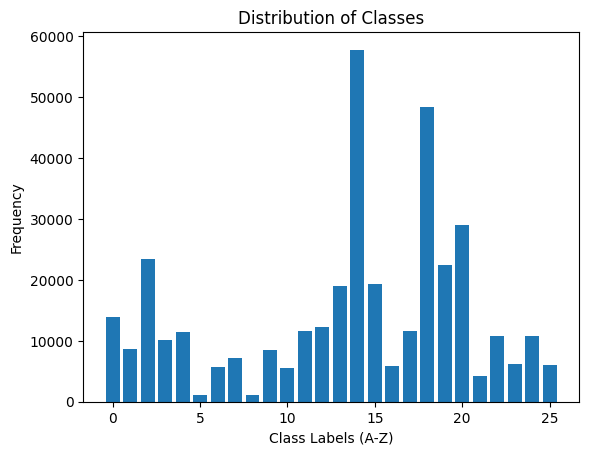

In [255]:
# We know that the fisrt column is the target 
# contains numbers from 0 to 25 (A-Z).

# Count the frequency of each letter
# df_pre["0"] to get the first column as its name is "0" from the above information
unique_classes, counts = np.unique(df_pre["0"], return_counts=True)

print ("Unique classes:", unique_classes)
print("Unique classes and their counts:")
for cls, count in zip(unique_classes, counts):
    print(f"{chr(cls + ord('A'))}: {count}")
print("-" * 80)

# show the distribution
plt.bar(unique_classes, counts)
plt.title("Distribution of Classes")
plt.xlabel("Class Labels (A-Z)")
plt.ylabel("Frequency")
plt.show()


>#### Normalize each image. 


In [256]:
# Normalize images
# divide by 255 to make the data between 0 and 1
df_normalized = df_pre.astype("float32") / 255.0


>#### Reshape the flattened vectors to reconstruct and display the corresponding images while testing the models. 

In [257]:

# Separate the target column (first column)
# we get it from the original dataset not from the normalized dataset 
# iloc[Rows , Columns] , ":" means all records , "0" mean the first column 
df_targets = df_pre.iloc[:, 0].values  

# Extract the image data (columns 2 to 785) and reshape each row into 28x28
# iloc[Rows , Columns] , ":" means all records , "1:" mean the second column to the last column 
# the data already is 2d array so the "images" will be 3d array 
# as in each index will contain 2d array ( 28 X 28 ) 
# "-1" automatically calculates the number of images based on the total data size. 
# mean will return the number of rows
df_images = df_normalized.iloc[:, 1:].values.reshape(-1, 28, 28)  


print("Images shape:", df_images.shape)

print("-"*80)

# the firts image in 2d array   
print(df_images[0])


Images shape: (372450, 28, 28)
--------------------------------------------------------------------------------
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0. 

>#### Letters Visualization

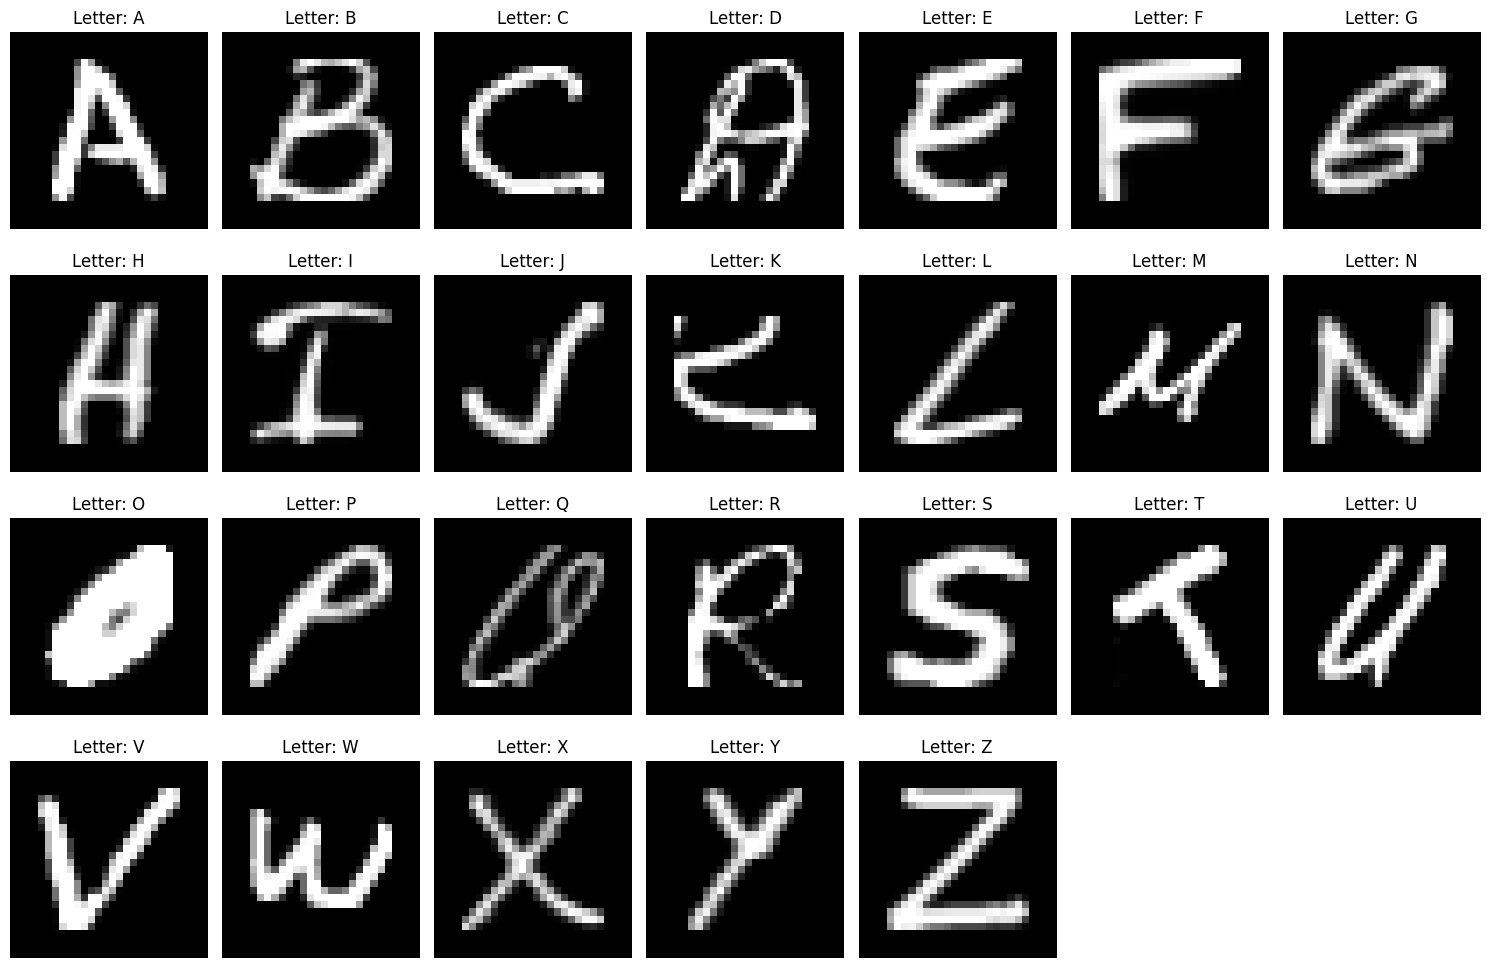

In [258]:
# we have the unique classes and its counts 
# we need cumulative sum to get index that represents each letter
# Create list from the cumulative sum as the following
# sum(count[:i]) means sum the counts from the first index to the i index
cumulative_counts = [sum(counts[:i]) for i in range(len(counts) + 1)]  


# Create a figure for displaying all letters
plt.figure(figsize=(15, 10))

# Loop through all 26 letters
for i, letter in enumerate(unique_classes):
    # Get the starting index for the current letter
    idx = cumulative_counts[i] + 20

    # Create a grid of 4 rows and 7 columns for visualization 
    plt.subplot(4, 7, i + 1)  
    
    # Display the image using "imshow" that used to display data as an image on a 2D
    plt.imshow(df_images[idx], cmap='gray')  

    # Show the letter as character not as number
    # "ord" get the ASCII representation then add the letter number 
    # then convert to character using casting "chr"
    plt.title(f"Letter: {chr(letter + ord('A'))}") 

    # Hide axes 
    plt.axis("off")  

plt.tight_layout()
plt.show()

>#### Split the data into training and testing datasets

In [259]:

# make the 80% from the data training set and 20% from the data testing set
# random state to ensure that the split return the same data each run


# The final test data will be worked on
df_images_train, df_images_test, df_targets_train, df_targets_test = train_test_split(df_images, df_targets, test_size=0.2, random_state=42) 



# Ensure that the training set and testing set contains all the unique classes

targets_train_unique_classes = np.unique(df_targets_train)

print("No. Of Unique classes in targets train : \n" ,len(targets_train_unique_classes) )
print("-"*80)

targets_test_unique_classes = np.unique(df_targets_test)

print("No. Of Unique classes in targets test : \n" ,len(targets_test_unique_classes) )
print("-"*80)



No. Of Unique classes in targets train : 
 26
--------------------------------------------------------------------------------
No. Of Unique classes in targets test : 
 26
--------------------------------------------------------------------------------


>#### Split the training dataset into training and validation datasets


In [260]:
# Split the training dataset into training and validation datasets
# random state to ensure that the split return the same data each run


# The final training data will be worked on

df_images_train_final, df_images_val, df_targets_train_final, df_targets_val = train_test_split(
    df_images_train, df_targets_train, test_size=0.2, random_state=42
)

# Ensure that the final training set and validation set contain all unique classes
targets_train_final_unique_classes = np.unique(df_targets_train_final)
targets_val_unique_classes = np.unique(df_targets_val)

targets_train_unique_classes = np.unique(df_targets_train)

print("No. Of Unique classes in targets train : \n" ,len(targets_train_unique_classes) )
print("-"*80)

targets_test_unique_classes = np.unique(df_targets_test)

print("No. Of Unique classes in targets test : \n" ,len(targets_test_unique_classes) )
print("-"*80)

No. Of Unique classes in targets train : 
 26
--------------------------------------------------------------------------------
No. Of Unique classes in targets test : 
 26
--------------------------------------------------------------------------------


## Neural Networks

####  Design 2 Neural Networks (with different number of hidden layers, neurons, activations, etc.)

In [268]:

# first neural network model with one hidden layer 
# the first layer is flatten layer to convert the 2d array to 1d array
# the second layer is dense layer with 256 neurons and relu activation function
# the last layer is dense layer with 26 neurons(No. Of letters from A to Z) and softmax activation function

model_a = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(26 , activation='softmax')
])


# Set the settings of the model 
# optimizer is the algorithm that will be used to minimize the loss function
# "adam" is the most popular optimizer
# loss function is the difference between the predicted value and the actual value
# "keras.losses.SparseCategoricalCrossentropy()" is used for classification problems with multiple classes
# metrics is used to evaluate the model performance 
model_a.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])


# second neural network model with three hidden layers
# the first layer is flatten layer to convert the 2d array to 1d array
# the second layer is dense layer with 256 neurons and relu activation function
# the third layer is dense layer with 128 neurons and relu activation function
# the fourth layer is dense layer with 64 neurons and softplus activation function
# the last layer is dense layer with 26 neurons(No. Of letters from A to Z) and softmax activation function

model_b = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='softplus'),
    tf.keras.layers.Dense(26 , activation='softmax')
])

model_b.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])



#### Train each one of these models and plot the error and accuracy curves for the training data and validation datasets.


Epoch 1/5
7449/7449 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.8798 - loss: 0.4388 - val_accuracy: 0.9639 - val_loss: 0.1309
Epoch 2/5
7449/7449 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.9681 - loss: 0.1101 - val_accuracy: 0.9715 - val_loss: 0.1035
Epoch 3/5
7449/7449 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.9778 - loss: 0.0770 - val_accuracy: 0.9750 - val_loss: 0.0908
Epoch 4/5
7449/7449 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.9830 - loss: 0.0580 - val_accuracy: 0.9751 - val_loss: 0.0901
Epoch 5/5
7449/7449 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - accuracy: 0.9856 - loss: 0.0485 - val_accuracy: 0.9776 - val_loss: 0.0828


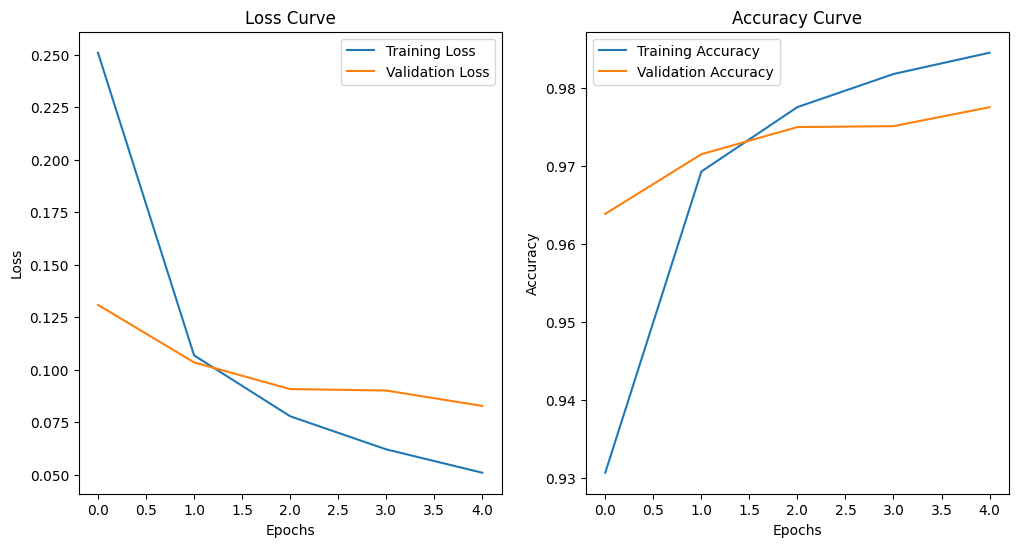

--------------------------------------------------------------------------------
Epoch 1/5
7449/7449 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.8754 - loss: 0.4427 - val_accuracy: 0.9600 - val_loss: 0.1372
Epoch 2/5
7449/7449 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.9666 - loss: 0.1126 - val_accuracy: 0.9720 - val_loss: 0.0983
Epoch 3/5
7449/7449 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.9760 - loss: 0.0795 - val_accuracy: 0.9753 - val_loss: 0.0867
Epoch 4/5
7449/7449 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.9806 - loss: 0.0633 - val_accuracy: 0.9755 - val_loss: 0.0865
Epoch 5/5
7449/7449 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.9840 - loss: 0.0510 - val_accuracy: 0.9781 - val_loss: 0.0815


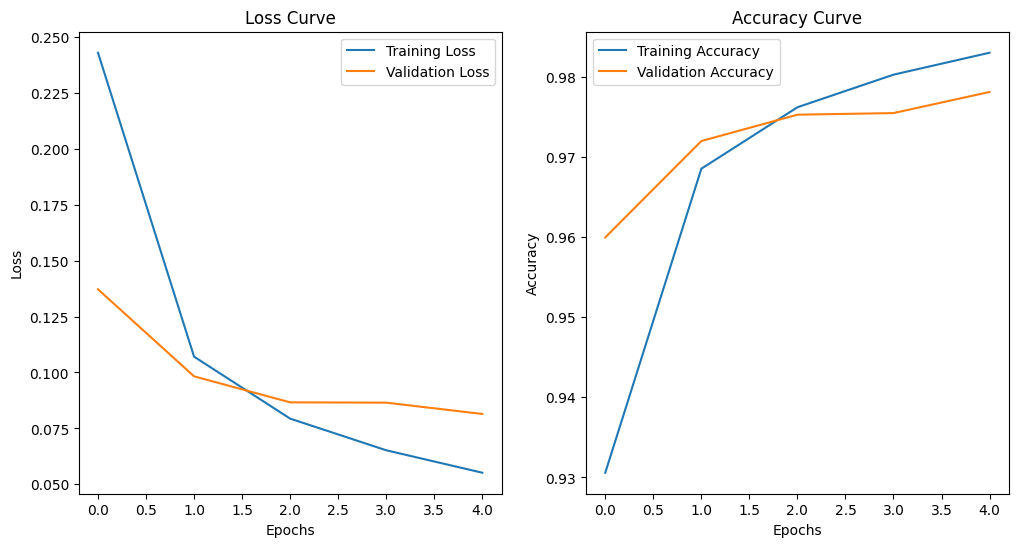

In [269]:

# Train the first model on the training data and validate on the validation data
# epochs is the number of times the model will be trained on the training data
# batch size is the number of samples that will be used in each iteration

history_a = model_a.fit(df_images_train_final, df_targets_train_final, validation_data=(df_images_val , df_targets_val),epochs=5 , batch_size=32)

# get the loss and accuracy 

loss_a = history_a.history['loss']
val_loss_a = history_a.history['val_loss']
accuracy_a = history_a.history['accuracy']
val_accuracy_a = history_a.history['val_accuracy']



# Plotting Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(loss_a, label='Training Loss')
plt.plot(val_loss_a, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracy_a, label='Training Accuracy')
plt.plot(val_accuracy_a, label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
print("-"*80)


# train the second model on the training data and validate on the validation data
history_b =  model_b.fit(df_images_train_final, df_targets_train_final, validation_data=(df_images_val , df_targets_val),epochs=5 , batch_size=32)


loss_b = history_b.history['loss']
val_loss_b = history_b.history['val_loss']
accuracy_b = history_b.history['accuracy']
val_accuracy_b = history_b.history['val_accuracy']



# Plotting Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(loss_b, label='Training Loss')
plt.plot(val_loss_b, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracy_b, label='Training Accuracy')
plt.plot(val_accuracy_b, label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


#### Save the best model in a separated file

In [263]:
# Compare the validation accuracy of both models
if max(accuracy_a) > max(accuracy_b):
    best_model = model_a
else:
    best_model = model_b

# Save the best model
best_model.save('best_model.keras')

#### Relod the model

In [3]:
best_model = tf.keras.models.load_model('best_model.keras')


#### Test the best model and provide the confusion matrix and the average f-1 scores for the testing data.

2328/2328 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


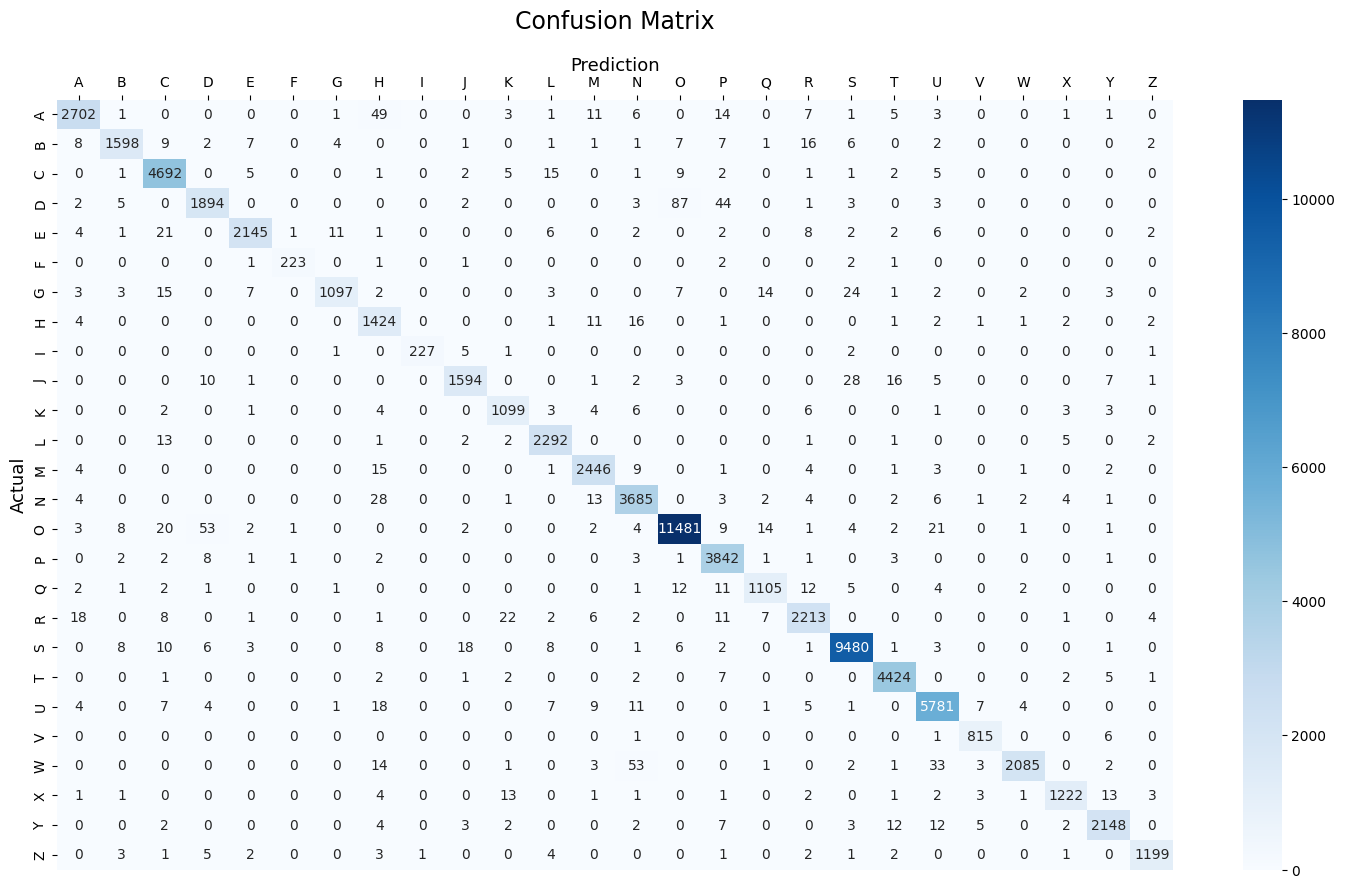

In [265]:
# Evaluate the best model on the testing data 

df_targets_predictions = best_model.predict(df_images_test)


# Get the class with the highest probability
# argmax return the index of the maximum value
# axis=1 to get the maximum value in each row
# the result will be the class label (0-25) of the letter
df_targets_predictions_classes = np.argmax(df_targets_predictions, axis=1)


# Get the confusion matrix 
cm = confusion_matrix(df_targets_test,df_targets_predictions_classes)

# class_labels to represent the letters from A to Z
class_labels = [chr(i + ord('A')) for i in range(26)]

# Plot the heatmap
plt.figure(figsize=(18, 10))
sns.heatmap(cm, 
            annot=True,         
            fmt='g',           
            cmap='Blues',       
            xticklabels=class_labels,  
            yticklabels=class_labels)  

plt.ylabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=17, pad=20)
plt.gca().xaxis.set_label_position('top')  
plt.xlabel('Prediction', fontsize=13)
plt.gca().xaxis.tick_top()                


plt.show()


#### Provide the average f-1 scores for the testing data.

In [266]:
# Get the classification report to get the F1-score avg
report = classification_report(df_targets_test, df_targets_predictions_classes, output_dict=True)

# get the F1-score for the 'weighted avg'
weighted_f1_score = report['weighted avg']['f1-score']

# Print the F1-score for the 'weighted avg'
print(f"Weighted Avg F1-score: {weighted_f1_score:.4f}")

Weighted Avg F1-score: 0.9788


#### Test the best model with images representing the alphabetical letters for the names of each member of your team.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicted name for AHMED: AHMED


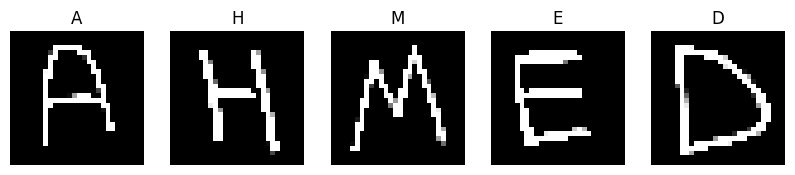

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Predicted name for SHAHD: SHAHD


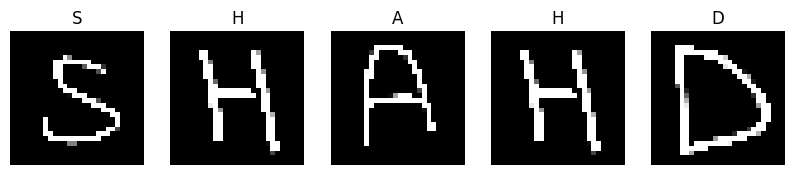

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Predicted name for SEIF: SEIF


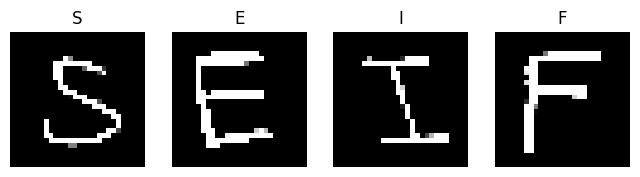

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Predicted name for MARYAM: MARYAM


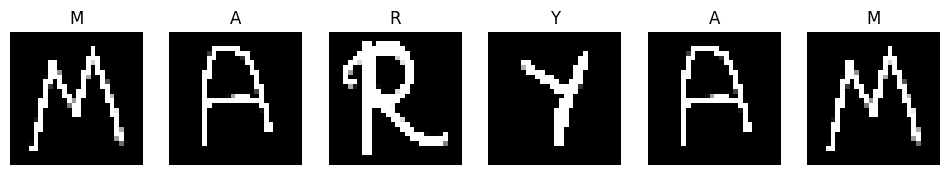

In [4]:
# List of team names to test the best model
names = ['AHMED', 'SHAHD', 'SEIF', 'MARYAM']

# Test each name
for name in names:
    # To store the predicted letters of the name
    predicted_name = []  
    
    # Create a subplot for each letter
    fig, ax = plt.subplots(1, len(name), figsize=(len(name) * 2, 2))
    
    # Loop through each letter of the name
    for i, letter in enumerate(name):
        # Get the image path for each letter
        image_path = f'letters/{letter}.png'
        
        # Load the image and resize it to (28, 28) with grayscale color
        img = load_img(image_path, target_size=(28, 28), color_mode='grayscale')

        # Normalize the image
        img_array = img_to_array(img) / 255.0  

        # Reshape to (1, 28, 28)
        img_array = np.expand_dims(np.squeeze(img_array), axis=0)  
        
        # Get predictions from the model
        predictions = best_model.predict(img_array)

        # Get the class index with the highest probability
        predicted_class_index = np.argmax(predictions)  

        # Map the class index to the letter
        predicted_letter = chr(predicted_class_index + ord('A'))  
        
        # Append the predicted letter to the predicted name
        predicted_name.append(predicted_letter)
        
        # Visualize the letter
        ax[i].imshow(img_array.squeeze(), cmap='gray')
        ax[i].axis('off')  
        ax[i].set_title(predicted_letter)  
    
    # Combine the predicted letters to form the full name
    predicted_full_name = ''.join(predicted_name)
    
    # Print the predicted name
    print(f"Predicted name for {name}: {predicted_full_name}")
    
    # Show the predicited name with its images
    plt.show()
